In [60]:
library(tidyverse)

# Here we train our final model using the parameters from before.
setwd("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/code/")
source("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/code/F01_functions.r")
best_params <- read.csv("../outputs/B_outputs/B11_lgb_grid_kyoto_best_params1.csv")
best_params


boostings,learning_rates,max_bins,min_data_in_leaf,num_leaves,max_depth,iteration,binary_logloss,auc,binary_error
<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
gbdt,0.1,255,20,60,10,52,0.292,0.935,0.121
dart,0.1,1800,10,60,-1,60,0.296,0.937,0.119
gbdt,0.1,500,10,60,10,42,0.293,0.935,0.118


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 140   9
         1  30  85
                                          
               Accuracy : 0.8523          
                 95% CI : (0.8036, 0.8928)
    No Information Rate : 0.6439          
    P-Value [Acc > NIR] : 3.232e-14       
                                          
                  Kappa : 0.6932          
                                          
 Mcnemar's Test P-Value : 0.001362        
                                          
            Sensitivity : 0.8235          
            Specificity : 0.9043          
         Pos Pred Value : 0.9396          
         Neg Pred Value : 0.7391          
             Prevalence : 0.6439          
         Detection Rate : 0.5303          
   Detection Prevalence : 0.5644          
      Balanced Accuracy : 0.8639          
                                          
       'Positive' Class : 0               
                              

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
Ca_cumsum,0.489410640,0.37916626,0.24593968
day,0.248501919,0.14964899,0.18700696
Cd_cumsum,0.064406817,0.08672071,0.12668213
daily_Ca,0.043150906,0.12372938,0.13225058
month,0.035490569,0.04104369,0.02691415
tmin,0.030699900,0.05854491,0.07285383
tmax,0.023102498,0.05201501,0.05986079
daily_Cd,0.021833465,0.04059535,0.06728538
long,0.019848525,0.03706995,0.03387471


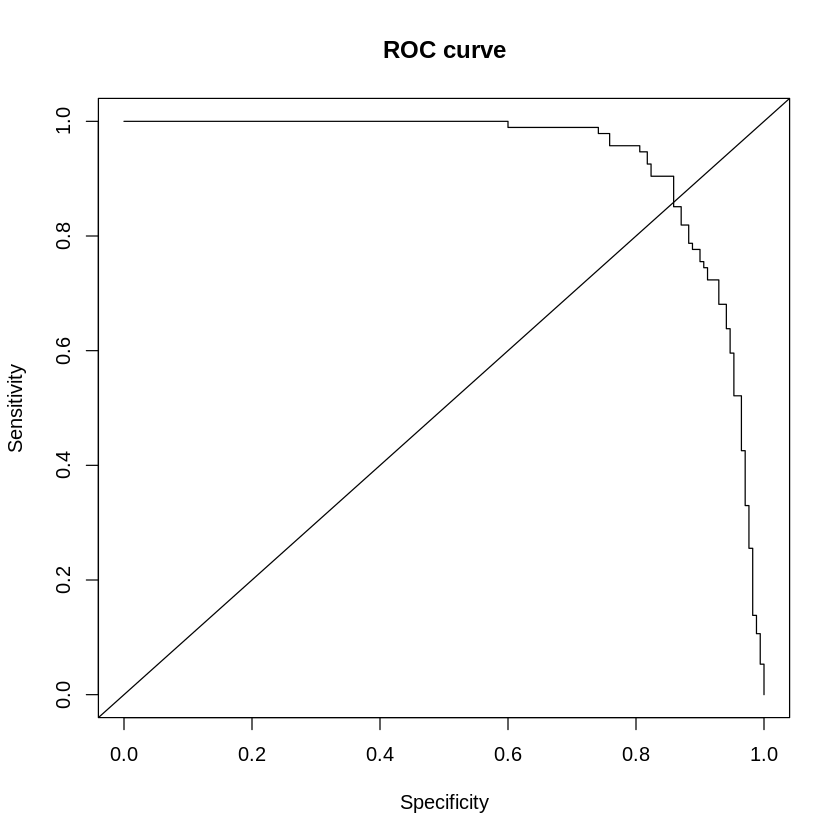

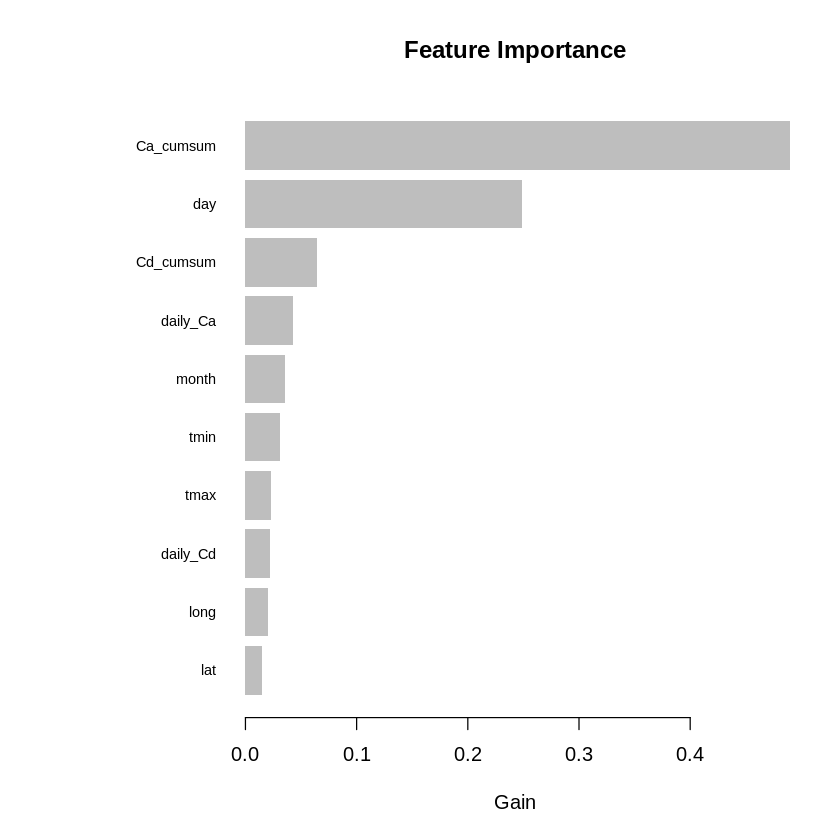

In [16]:
# Run below codes after running the above
library(tidyverse)
library(lightgbm)

lgb_load <- readRDS.lgb.Booster('../outputs/B_outputs/B21_lgb_final1.rds')
test_set <- read.csv("../outputs/B_outputs/B11_japan_test1.csv")
source("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/code/F01_functions.r")
# feature_names <- c("tmax", "tmin", "prcp", "month", "day", "daily_Ca", "daily_Cd", "Cd_cumsum", "Ca_cumsum", "lat", "long", "alt")
# target_col <- "is_bloom"

pred <- predict(lgb_load, as.matrix(test_set[, feature_names]))
test_set$predicted <- ifelse(pred > 0.5, 1, 0)

# Confusion matrix
library(caret)
confusionMatrix(factor(test_set$predicted), factor(test_set$is_bloom))

# ROC curve
library(ROCR)
roc_pred <- prediction(pred, test_set$is_bloom)
roc <- performance(roc_pred, "sens", "spec")
plot(roc, main="ROC curve")
abline(a=0, b=1)

# Feature importance
lgb_imp <- lgb.importance(lgb_load)
lgb_imp
lgb.plot.importance(lgb_imp, top_n = 10L, measure = "Gain")

In [20]:
cherry_main_data <- read.csv("../outputs/A_outputs/A11_kyoto_out.csv") %>%
    filter(year %in% 2012:2023) %>%
    dplyr::select(all_of(c("bloom_date", "lat", "long", "alt")))
# head(cherry_main_data)

gdd_data <- read.csv("../outputs/A_outputs/A41_gdd_kyoto.csv") %>%
    filter(year %in% 2012:2023) %>%
    filter(name == "KYOTO") %>%
    mutate(lat = unique(cherry_main_data$lat)) %>%
    mutate(long = unique(cherry_main_data$long)) %>%
    mutate(alt = unique(cherry_main_data$alt))
# head(gdd_data)
# dim(gdd_data)

# write.csv("../outputs/B_outputs/B21_kyoto_gdd_test.csv", row.names = FALSE)

# Make predictions
kyoto_gdd <- gdd_data
kyoto_years <- unique(kyoto_gdd$year)
error_cols <- c("year", "date", "pred_date", "diff")
error_table <- data.frame(matrix(nrow = length(kyoto_years), ncol = length(error_cols), dimnames = list(NULL, error_cols)))

p_thresh <- 0.70

for (y in seq_len(length(kyoto_years))) {
    
    yr <- kyoto_years[y]
    
    temp_data <- kyoto_gdd[kyoto_gdd$year == yr, ]
    pred <- predict(lgb_load, as.matrix(temp_data[, feature_names]))
    temp_data$pred_prob <- pred
    temp_data$pred_bin <- ifelse(pred > p_thresh, 1, 0)

    actual_bloom_idx <- which(temp_data$is_bloom == 1)
    actual_bloom_date <- temp_data[actual_bloom_idx, "date"]
    if (yr == 2022) {
        actual_bloom_date <- "2022-04-01"
    }
    
    pred_blooms <- which(temp_data$pred_bin == 1)
    # pred_bloom_start_idx <- pred_blooms[1]
    pred_bloom_start_idx <- which(temp_data$pred_prob == max(temp_data$pred_prob))[1] -2# take the highest probability day as the blooming date.
    pred_bloom_start_date <- temp_data[pred_bloom_start_idx, "date"]
    
    if (is.na(pred_bloom_start_date)) {
        pred_bloom_start_date <- temp_data[which(temp_data$pred_prob == max(temp_data$pred_prob))[1], "date"]
    }

    temp_diff <- as.numeric(as.Date(pred_bloom_start_date)) - as.numeric(as.Date(actual_bloom_date))
    error_table[y, ] <- c(yr, actual_bloom_date, pred_bloom_start_date, temp_diff)
}
error_table
mean(abs(as.numeric(error_table$diff)), na.rm = TRUE)

year,date,pred_date,diff
<chr>,<chr>,<chr>,<chr>
2012,2012-04-09,2012-04-07,-2
2013,2013-03-30,2013-04-02,3
2014,2014-04-02,2014-04-06,4
2015,2015-04-01,2015-03-30,-2
2016,2016-04-02,2016-03-27,-6
2017,2017-04-07,2017-04-04,-3
2018,2018-03-28,2018-03-26,-2
2019,2019-04-06,2019-04-04,-2
2020,2020-03-30,2020-03-30,0


[1] 2.363636

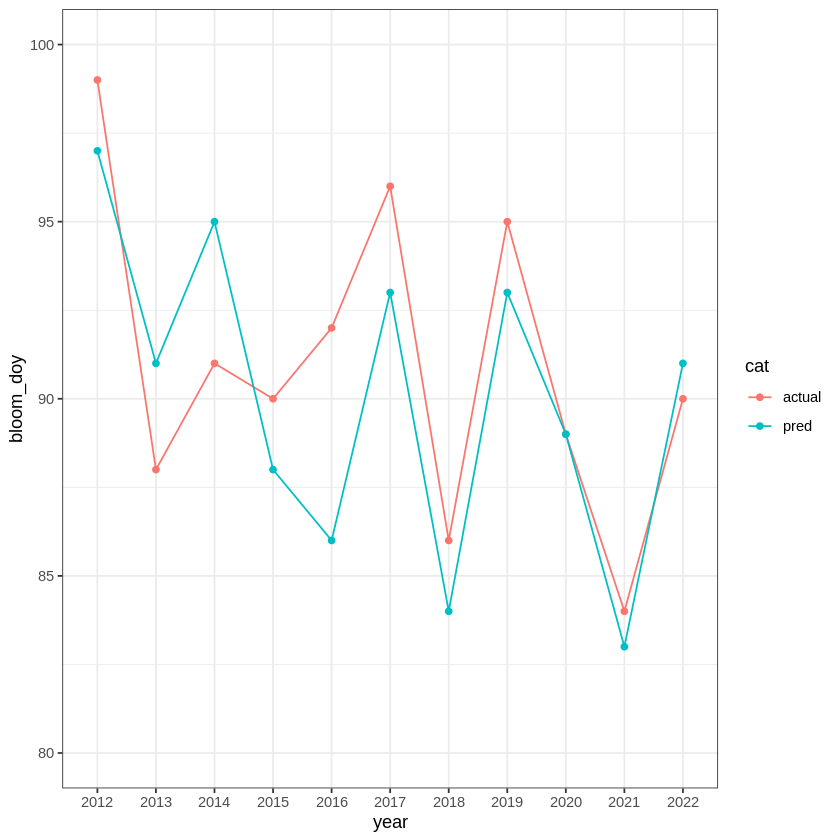

In [21]:
# plot bloom_doys

error_table2 <- error_table
error_table2$first_day <- as.Date(paste0(error_table2$year, "-01-01"))
error_table2$actual_bloom_doy <- as.numeric(as.Date(error_table2$date)) - as.numeric(as.Date(error_table2$first_day))
error_table2$pred_bloom_doy <- as.numeric(as.Date(error_table2$pred_date)) - as.numeric(as.Date(error_table2$first_day))
# head(error_table2)

error_table2_actual <- error_table2 %>% 
    select(year, date, actual_bloom_doy) %>% mutate(cat = "actual") %>% 
    rename_with(~"bloom_doy", actual_bloom_doy)

error_table2_pred <- error_table2 %>% select(year, pred_date, pred_bloom_doy) %>% mutate(cat = "pred") %>% 
    rename_with(~"bloom_doy", pred_bloom_doy) %>% 
    rename_with(~"date", pred_date)

error_table3 <- rbind(error_table2_actual, error_table2_pred)
# head(error_table3)

col_groups <- c("tomato", "dark green")

p <- ggplot(data = error_table3, mapping = aes(x = year, y = bloom_doy, group = cat, color = cat))
p <- p + geom_line()
p <- p + geom_point()
p <- p + theme_bw()
p <- p + ylim(c(80, 100))
p

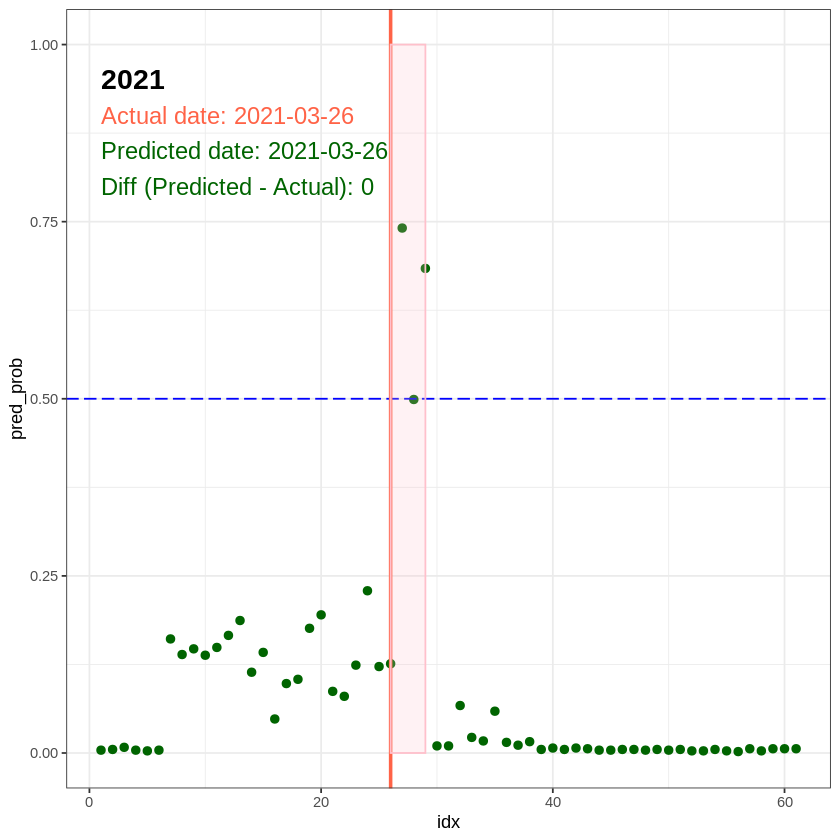

In [24]:
# for one year

yr = 2021
p_thresh <- 0.5
year_data <- gdd_data %>% filter(year == yr & name == "KYOTO" & month %in% c(3, 4)) %>%
    dplyr::select(all_of(c("date", feature_names, target_col)))
# head(year_data[year_data$is_bloom == 1, ])
# dim(year_data)

# Make prediction on this data

pred <- predict(lgb_load, as.matrix(year_data[, feature_names]))
year_data$pred_prob <- round(pred, 3) 
year_data$pred_bin <- ifelse(pred > p_thresh, 1, 0)
year_data$idx <- seq_len(nrow(year_data))
# year_data[, c("date", "is_bloom", "pred_prob", "pred_bin")]

actual_bloom_day_idx <- which(year_data$is_bloom == 1)
actual_bloom_day <- year_data[actual_bloom_day_idx, "date"]

predicted_bloom_days <- which(year_data$pred_bin == 1)
# predicted_bloom_day_idx <-predicted_bloom_days[1]
predicted_bloom_day_idx <- which(year_data$pred_prob == max(year_data$pred_prob))[1] -1 # take the highest probability day as the blooming date.
predicted_bloom_day <- year_data[predicted_bloom_day_idx, "date"]
predicted_bloom_end_idx <- predicted_bloom_days[length(predicted_bloom_days)]

diff_days <- as.numeric(as.Date(predicted_bloom_day)) - as.numeric(as.Date(actual_bloom_day))

p <- ggplot(data = year_data)
p <- p + geom_point(aes(x = idx, y = pred_prob), color = "dark green", lwd = 2)
p <- p + ylim(c(0, 1))
p <- p + geom_hline(yintercept = p_thresh, color = "blue", linetype = "longdash")
p <- p + geom_vline(xintercept = actual_bloom_day_idx, color = "tomato", linetype = "solid", lwd = 1)
p <- p + theme_bw()
p <- p + annotate("text", x = 1, y = 0.95, label = yr, fontface = "bold", color = "black", size = 6, hjust = 0)
p <- p + annotate("text", x = 1, y = 0.90, label = paste0("Actual date: ", actual_bloom_day), size = 5, color = "tomato", hjust = 0)
p <- p + annotate("text", x = 1, y = 0.85, label = paste0("Predicted date: ", predicted_bloom_day), size = 5, color = "dark green", hjust = 0)
p <- p + annotate("text", x = 1, y = 0.80, label = paste0("Diff (Predicted - Actual): ", diff_days), color = ifelse(diff_days > 0, "tomato", "dark green"), size = 5, hjust = 0)
p <- p + annotate("rect", xmin = predicted_bloom_day_idx, xmax = predicted_bloom_end_idx
            , ymin = 0, ymax = 1, alpha = 0.2, color = "pink", fill = "pink")
p

In [107]:
diff_days <- as.numeric(as.Date(actual_bloom_day)) - as.numeric(as.Date(predicted_bloom_day))
diff_days

[1] 2

using cached file: ~/.cache/R/noaa_ghcnd/JA000047759.dly

date created (size, mb): 2023-02-06 22:23:45 (1.687)

file min/max dates: 1945-10-01 / 2023-02-28




 iter imp variable
  1   1  tmax  tmin  prcp
  1   2  tmax  tmin  prcp
  1   3  tmax  tmin  prcp
  1   4  tmax  tmin  prcp
  1   5  tmax  tmin  prcp
  2   1  tmax  tmin  prcp
  2   2  tmax  tmin  prcp
  2   3  tmax  tmin  prcp
  2   4  tmax  tmin  prcp
  2   5  tmax  tmin  prcp
  3   1  tmax  tmin  prcp
  3   2  tmax  tmin  prcp
  3   3  tmax  tmin  prcp
  3   4  tmax  tmin  prcp
  3   5  tmax  tmin  prcp
  4   1  tmax  tmin  prcp
  4   2  tmax  tmin  prcp
  4   3  tmax  tmin  prcp
  4   4  tmax  tmin  prcp
  4   5  tmax  tmin  prcp
  5   1  tmax  tmin  prcp
  5   2  tmax  tmin  prcp
  5   3  tmax  tmin  prcp
  5   4  tmax  tmin  prcp
  5   5  tmax  tmin  prcp


Warning message:
“Number of logged events: 4”


,id,date,year,month,day,tmin,tmax
,<chr>,<date>,<int>,<int>,<int>,<dbl>,<dbl>
1,JA000047759,2022-01-01,2022,1,1,-2.7,5.6
2,JA000047759,2022-01-02,2022,1,2,-0.9,9.4
3,JA000047759,2022-01-03,2022,1,3,0.6,11.6
4,JA000047759,2022-01-04,2022,1,4,1.5,8.4
5,JA000047759,2022-01-05,2022,1,5,2.0,6.6
6,JA000047759,2022-01-06,2022,1,6,-2.1,6.8


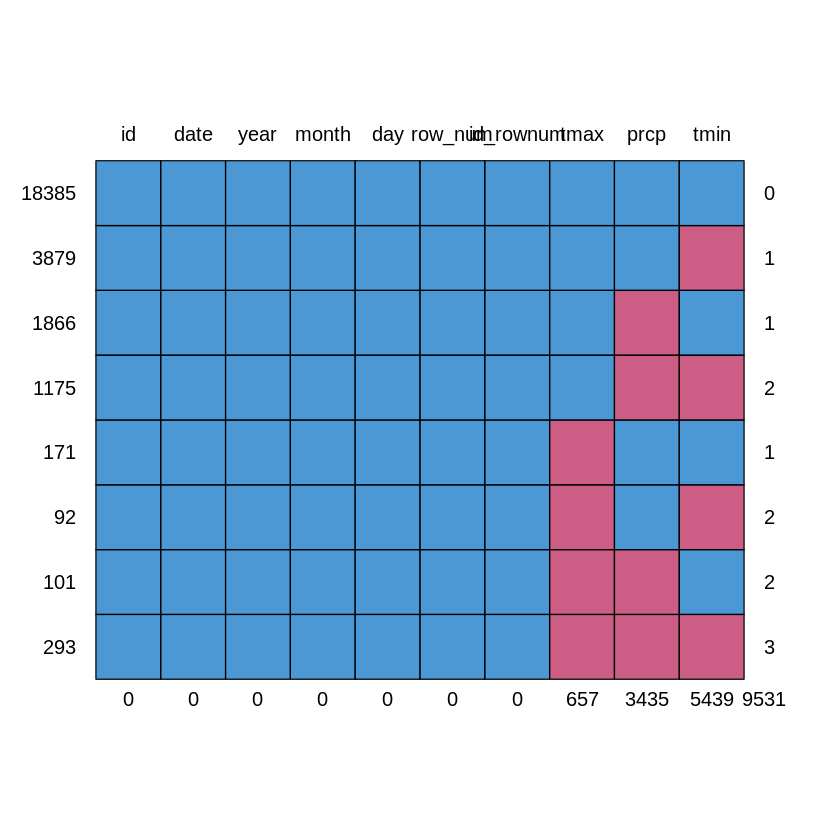

In [64]:
kyoto_temp <- F01_get_imp_temperature(station_ids = c("JA000047759"), date_min = "2022-10-01", date_max = "2023-04-30", imp_method = "pmm") %>% 
    mutate(year = as.integer(strftime(date, format = "%Y"))) %>%
    filter(year %in% c(2022, 2023)) %>%
    select(id, date, year, month, day, tmin, tmax) %>% "rownames<-"(NULL)
head(kyoto_temp)

In [51]:
tail(kyoto_temp)

,id,date,year,month,day,tmin,tmax
,<chr>,<date>,<int>,<int>,<int>,<dbl>,<dbl>
419,JA000047759,2023-02-23,2023,2,23,19.9,29.7
420,JA000047759,2023-02-24,2023,2,24,24.3,33.6
421,JA000047759,2023-02-25,2023,2,25,19.8,30.3
422,JA000047759,2023-02-26,2023,2,26,7.0,15.2
423,JA000047759,2023-02-27,2023,2,27,0.1,12.8
424,JA000047759,2023-02-28,2023,2,28,-1.2,6.2


In [65]:
data_2023 <- read.csv("../data/2023-mar-apr-kyoto.csv") %>%
    mutate(id = "JA000047759") %>%
    mutate(year = 2023) %>%
    mutate(month = as.integer(strftime(date, "%m"))) %>%
    mutate(day = as.integer(strftime(date, "%d"))) %>%
    select(id, date, year, month, day, tmin, tmax)
# head(data_2023)

merged_test <- rbind(kyoto_temp, data_2023) %>% "rownames<-"(NULL)
head(merged_test)

,id,date,year,month,day,tmin,tmax
,<chr>,<date>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,JA000047759,2022-01-01,2022,1,1,-2.7,5.6
2,JA000047759,2022-01-02,2022,1,2,-0.9,9.4
3,JA000047759,2022-01-03,2022,1,3,0.6,11.6
4,JA000047759,2022-01-04,2022,1,4,1.5,8.4
5,JA000047759,2022-01-05,2022,1,5,2.0,6.6
6,JA000047759,2022-01-06,2022,1,6,-2.1,6.8


In [68]:
write.csv(merged_test, "../outputs/B_outputs/B21_kyoto_temp_2223.csv", row.names = FALSE)

In [63]:
unique(merged_test$month)

[1]  1  2  3  4  5  6  7  8  9 10 11 12

In [62]:
head(merged_test_temp)

id,date,year,month,day,tmin,tmax,daily_Cd,daily_Ca,Cd_cumsum,Ca_cumsum,diff_Ca_Cd,diff_Ca_Cd_cumsum
<chr>,<date>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [27]:
## Final prediction

# download weather forecasts for 2023-03-01 - 2023-04-15
# https://www.accuweather.com/en/jp/kyoto-shi/224436/march-weather/224436?year=2023



# Merge with 2022 data
# head(data_2023)

# compute daily_Ca, daily_Cd, Ca_cumsum, Cd_cumsum
data_2023$year <- 2023
data_2023$month <- as.integer(strftime(data_2023$date, "%m"))
data_2023$day <- as.integer(strftime(data_2023$date, "%d"))
head(data_2023)
# data_2023$daily_Cd <- apply(data_2023, MARGIN = 1, FUN = F01_chill_days)[1, ]
# data_2023$daily_Ca <- apply(data_2023, MARGIN = 1, FUN = F01_chill_days)[2, ]
# data_2023$Cd_cumsum <- cumsum(data_2023$daily_Cd)
# data_2023$Ca_cumsum <- cumsum(data_2023$daily_Ca)


# kyoto <- read.csv("../data/kyoto.csv")
# data_2023$lat <- unique(kyoto$lat)
# data_2023$long <- unique(kyoto$long)
# data_2023$alt <- unique(kyoto$alt)

# head(data_2023)

,date,tmax,tmin,year,month,day
,<chr>,<int>,<int>,<dbl>,<int>,<int>
1,2023-03-01,8,-1,2023,3,1
2,2023-03-02,9,1,2023,3,2
3,2023-03-03,13,0,2023,3,3
4,2023-03-04,8,0,2023,3,4
5,2023-03-05,9,1,2023,3,5
6,2023-03-06,10,3,2023,3,6


In [25]:
# Final prediction for 2023

data_2023 
p_thresh <- 0.5
pred <- predict(lgb_load, as.matrix(data_2023[, feature_names]))
data_2023$pred_prob <- round(pred, 3) 
data_2023$idx <- seq_len(nrow(data_2023))

predicted_bloom_days <- which(data_2023$pred_prob > p_thresh)
predicted_bloom_start_idx <- predicted_bloom_days[1]
predicted_bloom_end_idx <- predicted_bloom_days[length(predicted_bloom_days)]

predicted_bloom_start_date <- data_2023[predicted_bloom_start_idx, "date"]
predicted_bloom_end_date <- data_2023[predicted_bloom_end_idx, "date"]

peak_bloom_day_idx <- which(data_2023$pred_prob == max(data_2023$pred_prob))[1] # take the highest probability day as the blooming date.
peak_bloom_date <- data_2023[peak_bloom_day_idx, "date"]


p <- ggplot(data = data_2023)
p <- p + annotate("rect", xmin = predicted_bloom_start_idx, xmax = predicted_bloom_end_idx
            , ymin = 0, ymax = 1, alpha = 0.2, color = "pink", fill = "pink", lwd = 1.5)
p <- p + geom_point(aes(x = idx, y = pred_prob), color = "dark green", lwd = 2)
p <- p + ylim(c(0, 1))
p <- p + geom_vline(xintercept = peak_bloom_day_idx, color = "tomato", linetype = "longdash")
p <- p + geom_hline(yintercept = p_thresh, color = "grey", linetype = "longdash")
p <- p + theme_bw()
p <- p + annotate("text", x = 1, y = 0.95, label = "2023", fontface = "bold", color = "black", size = 6, hjust = 0)
p <- p + annotate("text", x = 1, y = 0.85, label = paste0("Predicted date: ", peak_bloom_date), size = 5, color = "dark green", hjust = 0)
p

ERROR: Error in as.matrix(data_2023[, feature_names]): object 'data_2023' not found


In [1]:
setwd("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/code/")
load("../outputs/B_outputs/B11_lgb_grid_kyoto_par2.RData")

In [7]:
grid_search <- expand.grid(boostings = c("dart", "gbdt")
                           , learning_rates = c(0.1, 0.01) # 
                           , max_bins = c(255, 25, 500, 125) 
                           , min_data_in_leaf = c(20, 40, 10)
                           , num_leaves = c(31, 60, 100)
                           , max_depth = c(-1, 10, 30)
) %>%
    mutate(iteration = NA) %>%
    mutate(binary_logloss = NA) %>%
    mutate(auc = NA) %>%
    mutate(binary_error = NA)